In [6]:
import numpy as np
import xarray as xr
import nlopt
from statsrat import perform_oat, make_sim_data, learn_plot
from statsrat.expr.predef.cat import ibre, lrn_pred
from statsrat.rw.predef import smpr
from statsrat.rw import shrinkage
from statsrat.rw.fbase import elem
from plotnine import ggplot, geom_point, geom_line, aes, stat_smooth, facet_wrap

In [7]:
#n = 5
n = 20
#max_time = 5
max_time = 120
#algorithm = nlopt.GN_DIRECT_L
algorithm = nlopt.GN_AGS
#algorithm = nlopt.GN_ORIG_DIRECT
#algorithm = nlopt.GD_STOGO

In [9]:
m = shrinkage.model(name = 'elemental shrinkage', fbase = elem)
print(m.pars)
print(shrinkage.pars)
pars = [2, 2, 1, 0.1, 0.2, 1]

trials = lrn_pred.make_trials()
#print(trials)
#print(trials['u_psb'].loc[ds.stage_name == 'transfer'])
ds = m.simulate(trials, par_val = pars)
#print(ds['shrink_cond'].mean())
#print(ds['u_psb'].loc[ds.stage_name == 'transfer'])
#print(np.sum(ds['Sigma'].loc[{'t' : 20, 'u_name' : 'cat1'}] - ds['Sigma'].loc[{'t' : 20, 'u_name' : 'cat2'}]))

             min   max  default
alpha0       1.0  10.0     2.00
beta0        0.0  10.0     2.00
u_var        0.0   5.0     0.10
lrate_tausq  0.0   0.5     0.25
resp_scale   0.0  10.0     1.00
             min   max  default
alpha0       1.0  10.0     2.00
beta0        0.0  10.0     2.00
u_var        0.0   5.0     0.10
lrate_tausq  0.0   0.5     0.25
resp_scale   0.0  10.0     1.00


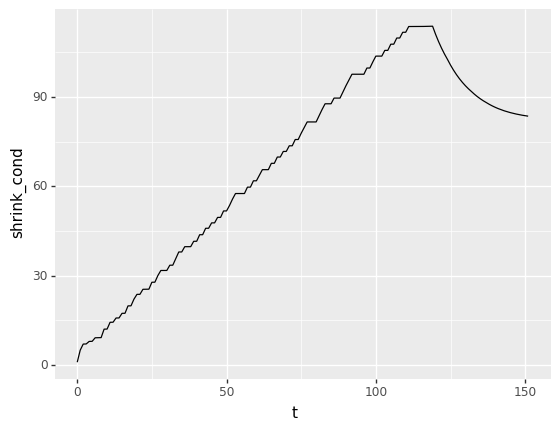

<ggplot: (-9223372025815449891)>

In [10]:
learn_plot(ds, 'shrink_cond', sel = {'u_name' : ['cat1']})

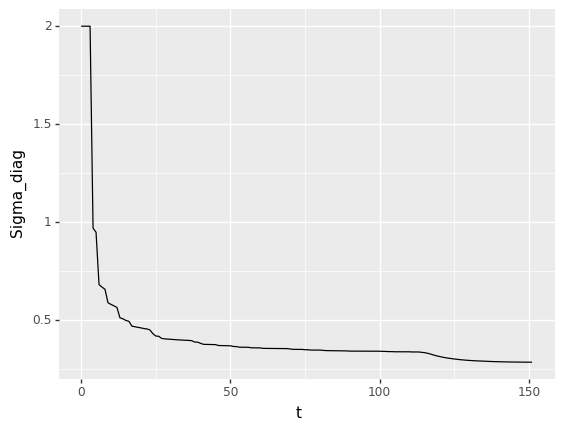

<ggplot: (11040134152)>

In [11]:
learn_plot(ds, 'Sigma_diag', sel = {'f_name' : ['b'], 'u_name' : ['cat1']})

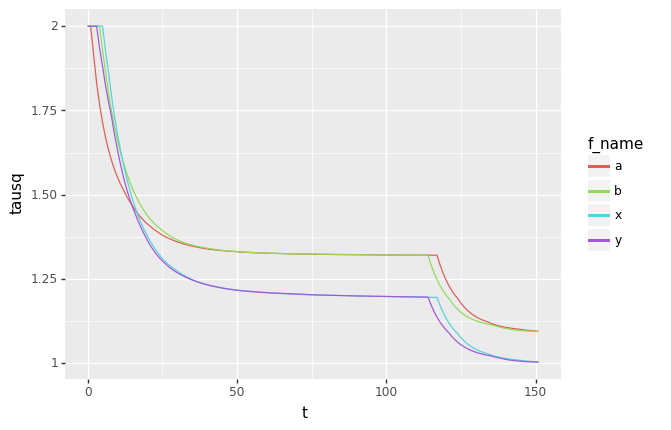

<ggplot: (-9223372025814638332)>

In [12]:
var = 'tausq'
#var = 'alpha'
#var = 'beta'
learn_plot(ds, var, sel = {'f_name' : ['a', 'b', 'x', 'y']})

/Users/sam/miniconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


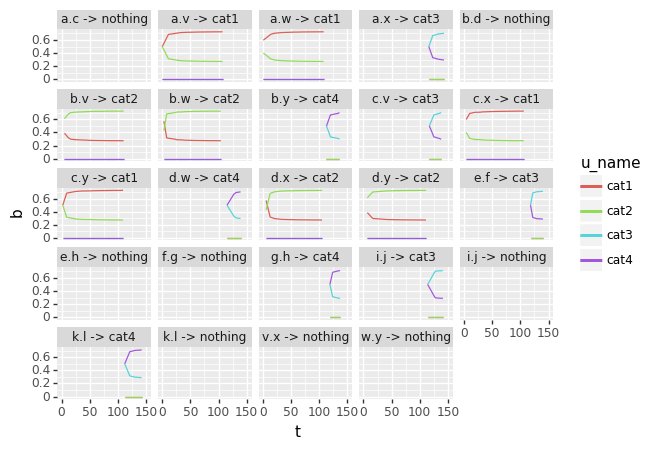

<ggplot: (-9223372025814593662)>

In [13]:
var = 'b'
#df = ds[var].loc[{'u_name' : ['cat3', 'cat4']}].to_dataframe()
df = ds[var].to_dataframe()
# Forget the chained indexing for now.
#df = ds[var].loc[ds.stage_name == 'transfer'].loc[{'u_name' : ['cat1', 'cat2']}].to_dataframe()
df = df.reset_index()
(ggplot(df, aes(x='t', y=var, color='u_name'))
 + geom_line()
 + facet_wrap('~trial_name'))

In [14]:
# ordinal adequacy test (OAT) for the IBRE
oat_result = perform_oat(m, ibre, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(2))

     alpha0  beta0  u_var  lrate_tausq  mean  lower  upper
min     1.0    0.0    2.5         0.25 -0.76  -0.76  -0.76
max     5.5   10.0    0.0         0.25 -0.00  -0.00  -0.00


In [15]:
# ordinal adequacy test (OAT) for learned predictiveness
oat_result = perform_oat(m, lrn_pred, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(5))

     alpha0    beta0    u_var  lrate_tausq     mean    lower    upper
min  9.9979  0.00222  2.49939      0.25006  0.00000  0.00000  0.00000
max  9.9979  0.00222  0.00161      0.24994  0.49345  0.49345  0.49345
